# Mathematical Underpinnings - Lab 7

In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [3]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    n = len(mu1)
    sigma2_inv = np.linalg.inv(Sigma2)
    return 0.5 * ((mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1) + np.trace(sigma2_inv @ Sigma1) - np.log(np.linalg.det(Sigma1) / np.linalg.det(Sigma2)) - n)

In [4]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    return np.log(st.multivariate_normal.pdf(x, mu1, Sigma1) / st.multivariate_normal.pdf(x, mu2, Sigma2))

### b)

In [5]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)
n = 10000
d = 5
mu1 = np.array([.2, .2, .2, 0, 0])
mu2 = np.array([0, 0, .2, .2, .2])
Sigma1 = 0.1 * np.ones((d, d)) + 0.9 * np.diag(np.ones(d))
Sigma2 = -0.2 * np.ones((d, d)) + 1.2 * np.diag(np.ones(d))

rng = np.random.default_rng(1234)

X1 = rng.multivariate_normal(mu1, Sigma1, size=n)
X2 = rng.multivariate_normal(mu2, Sigma2, size=n)
X = np.vstack([X1, X2])
Y = np.hstack([np.ones(n), np.zeros(n)]).astype(np.float64)

In [6]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)

    return np.sum(t * y) / n1 - np.log(np.sum(np.exp(t) * (1 - y)) / n2)

In [7]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [8]:
DV_fun(Y, T_opt(X, mu1, mu2, Sigma1, Sigma2))

2.031515930200751

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [10]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(256, activation='softplus')(model_inputs)
# layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(256)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [12]:
hist = model.fit(x_train, y_train, epochs=1000, batch_size=256, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -0.0196 - val_loss: -0.0282
Epoch 2/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0339 - val_loss: -0.0354
Epoch 3/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0399 - val_loss: -0.0408
Epoch 4/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0384 - val_loss: -0.0450
Epoch 5/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0429 - val_loss: -0.0482
Epoch 6/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0551 - val_loss: -0.0505
Epoch 7/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0581 - val_loss: -0.0524
Epoch 8/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0531 - val_loss: -0.0539
Epoch 9/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0559 - val_loss: -0.0549
Epoch 10/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0652 - val_loss: -0.0558
Epoch 11/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0560 - val_loss: -0.0565
Epoch 12/1000
59/59 ━━━━━━━━━━

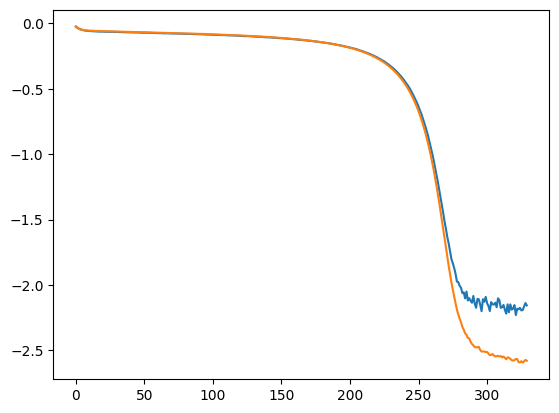

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [23]:
t_x_pred = model.predict(X)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [24]:
t_x_opt = T_opt(X, mu1, mu2, Sigma1, Sigma2)

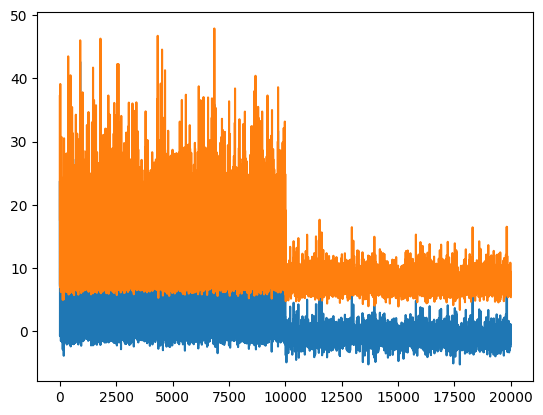

In [25]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

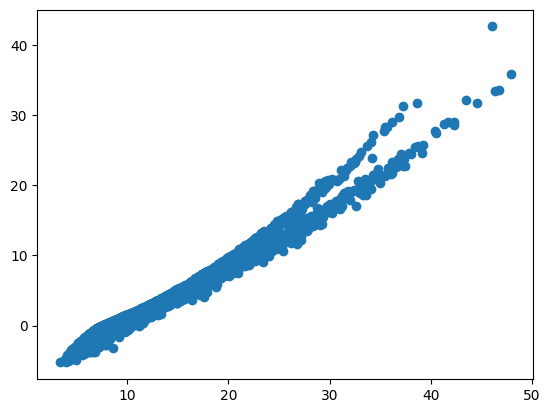

In [26]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [27]:
DV_fun(Y, t_x_pred.reshape(-1))

1.4111092866096726

In [28]:
DV_fun(Y, t_x_opt)

2.031515930200751

In [29]:
# new data
rng = np.random.default_rng(1237)

X1 = rng.multivariate_normal(mu1, Sigma1, size=n)
X2 = rng.multivariate_normal(mu2, Sigma2, size=n)
X_new = np.vstack([X1, X2])
Y_new = np.hstack([np.ones(n), np.zeros(n)]).astype(np.float64)

t_x_pred = model.predict(X)
t_x_opt = T_opt(X, mu1, mu2, Sigma1, Sigma2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [30]:
DV_fun(Y, t_x_pred.reshape(-1))

1.4111092866096726

In [31]:
DV_fun(Y, t_x_opt)

2.031515930200751

### f)

In [32]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.subtract(tf.math.exp(T_x), tf.convert_to_tensor(1.0)) , tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term)

In [33]:
def NWJ_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)

    return np.sum(t * y) / n1 - (np.sum((np.exp(t) - 1) * (1 - y)) / n2)

In [34]:
NWJ_fun(Y, t_x_opt)

2.0244946382506206

In [35]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
# layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
hist = model.fit(x_train, y_train, epochs=1000, batch_size=256, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.0306 - val_loss: -0.0199
Epoch 2/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0360 - val_loss: -0.0268
Epoch 3/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0396 - val_loss: -0.0322
Epoch 4/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0450 - val_loss: -0.0364
Epoch 5/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0481 - val_loss: -0.0397
Epoch 6/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0565 - val_loss: -0.0423
Epoch 7/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0699 - val_loss: -0.0447
Epoch 8/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0614 - val_loss: -0.0467
Epoch 9/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0686 - val_loss: -0.0484
Epoch 10/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0708 - val_loss: -0.0501
Epoch 11/1000
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0720 - val_loss: -0.0516
Epoch 12/1000
59/59 ━━━━━━━━━━

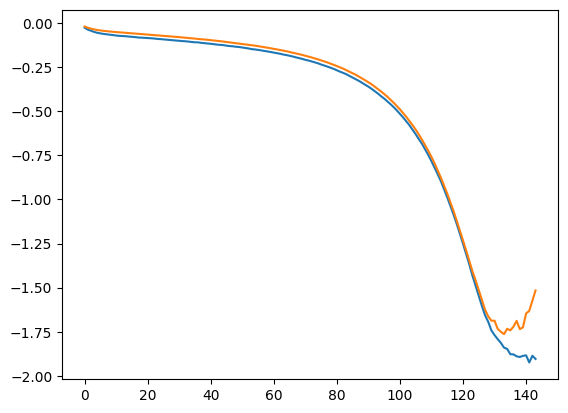

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [38]:
t_x_pred = model.predict(X)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [39]:
NWJ_fun(Y, t_x_pred.reshape(-1))

1.812392336396128

In [40]:
NWJ_fun(Y, t_x_opt)

2.0244946382506206

In [41]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572